## Code_Changes_Lines
This is the reference implementation for [Code_Changes_Lines](https://github.com/chaoss/wg-evolution/blob/master/metrics/Code_Changes_Lines.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Code_Changes_Lines
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from code_df import utils
from code_df import conditions
from code_df.commit import Commit
%matplotlib inline

In [2]:
class CodeChangesLines(Commit):
    """Class for Code_Changes for Git repositories.

    :param items: A list of dictionaries, each element a line from the
        JSON file with Perceval data

    :param date_range: A tuple which represents the start and end date of
        interest

    :param is_code:  list of CodeCondition objects
        It is used to determine what comprises source code.

    :param conds: A list of Commit objects. It is used to
        exclude or include different kinds of commits, like
        empty or merge commits, or commits made on the master
        branch.
    """

    def __init__(self, items, date_range=(None, None), is_code=[conditions.Naive()],
                 conds=[]):
        super().__init__(items, date_range, is_code, conds)

        self.df = self._add_lines_modified_cols(self.df)

    def compute(self):
        """
        Count number of commits of different types, like including empty commits
        or counting only those commits made on the master branch.

        :returns modified: A tuple representing the number of lines
            modified. modified -> (additions, deletions)
        """

        df = self.df
        additions = df['additions'].sum()
        deletions = df['deletions'].sum()

        modified = (additions, deletions)

        return modified

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame or Series
        to find the total number of lines modified in a every interval
        of the period specified in the time_series method, like
        'M', 'W',etc.

        It adds the number of lines modified for every row in the
        series.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The aggregated dataframe, where aggregations have
            been perform on "additions" and "deletions" columns
        """

        df = df.resample(period).agg({"additions": 'sum', "deletions": 'sum'})

        return df

    def _add_lines_modified_cols(self, df):

        if len(df) == 0:
            raise ValueError("DataFrame empty. "
                             "Please check instantiation parameters")

        additions = list()
        deletions = list()
        for _, commit in df.iterrows():
            added_lines = 0
            removed_lines = 0
            for file in commit['files']:
                if 'action' in file:
                    try:
                        added_lines += int(file['added'])
                        removed_lines += int(file['removed'])
                    except:
                        pass

            additions.append(added_lines)
            deletions.append(removed_lines)

        df['additions'] = additions
        df['deletions'] = deletions

        return df

## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 
For starters, we can perform a simple calculation of the number of modified lines (additions and deletions) in the file. To make things simple, we will use the `Naive` implementation for deciding whether a given commit affects the source code or not. Again, the naive implementation assumes that all files are part of the source code, and hence, all commits are considered to affect it. The `Naive` implementation is the default option. 

### Counting the total number of modified lines 
We first read the JSON file containing Perceval data using the `read_json_file` utility function. 

In [3]:
items = utils.read_json_file('../git-commits.json')

Let's use the `compute` method to count the total number of lines modified. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.

In [4]:
changes = CodeChangesLines(items)
print("The total number of modified lines (additions, deletions) "
      "in the file is {}.".format(changes.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")    

changes_dated = CodeChangesLines(items,
                        date_range=(date_since, date_until))
                        
print("The total number of lines modified (additions, deletions) between "
      "2018-01-01 and 2018-07-01 is {}.".format(changes_dated.compute()))

The total number of modified lines (additions, deletions) in the file is (254408, 98416).
The total number of lines modified (additions, deletions) between 2018-01-01 and 2018-07-01 is (64874, 29173).


### Counting the total number of lines modified by commits excluding merge commits
Moving on, lets make use of the `EmptyExclude` and `MergeExclude` classes to filter out empty and merge commits respectively. These classes are sub-classes of the `Commit` class in the `conditions` module. They provide two methods: `check()` and `set_commits`.

The `set_commits` method selects commits which satisfy a given condition (like excluding empty commits, for example) and stores the hashes of those commits in the set `included`, an instance variable of all `Commit` classes. 

The `check()` method checks each commit in the DataFrame created from Perceval data and drops those rows which correspond to commits not in `included`. 

In [5]:
changes_non_merge = CodeChangesLines(items, 
                                  (date_since, date_until),
                                  conds=[conditions.MergeExclude()])
print("The total number of lines modified (additions, deletions) by non-merge commits between"
      " 2018-01-01 and 2018-07-01 is {}.".format(changes_non_merge.compute()))

The total number of lines modified (additions, deletions) by non-merge commits between 2018-01-01 and 2018-07-01 is (64874, 29173).


## Counting the number of lines modified over regular time intervals
Using the `time_series` method, it is possible to compute the number of lines modified every month, or every week. This kind of analysis is useful in finding trends over time, as we will see in the cell below.

Let's perform a basic analysis: lets see the change in the number of lines modified between the same dates we used above on a weekly basis: 2018-01-01 and 2018-07-01. 
The Code_CHhanges_Lines object, `changes_dated`, will be the same as used above.

In [6]:
weekly_df = changes_dated.time_series(period='W')

Lets see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. To do this, we simply set the `created_date` column of the DataFrame `changes_dated.df`, as its index and then `resample` it to whatever time period we need. In this case, we have used `W`. We will apply the 'sum' aggregation function on both the 'additions' and 'deletions' columns of the dataframe.

In [7]:
weekly_df

,additions,deletions
created_date,,
2018-01-07,50,5
2018-01-14,118,57
2018-01-21,3363,3479
2018-01-28,1025,518
2018-02-04,684,100
2018-02-11,647,174
2018-02-18,415,2494
2018-02-25,194,20
2018-03-04,2050,272


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- lines modified vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plots and the x axis.

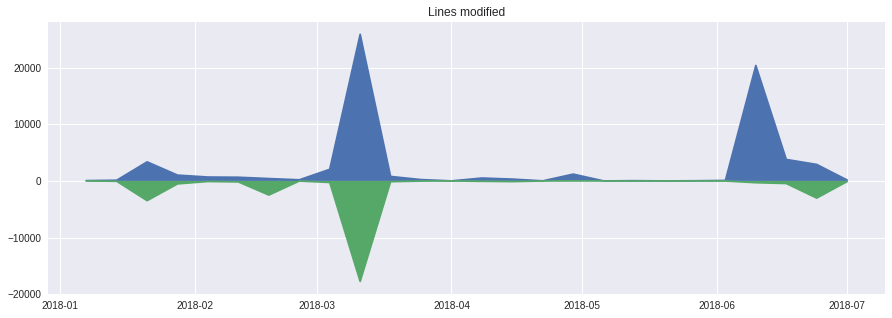

In [9]:
plt.figure(figsize=[15, 5])
plt.style.use('seaborn')
plt.plot(weekly_df['additions'])
plt.plot(-weekly_df['deletions'])

plt.fill_between(y1=weekly_df['additions'], y2=0, x=weekly_df.index)
plt.fill_between(y1=-weekly_df['deletions'], y2=0, x=weekly_df.index)
plt.title("Lines modified");
plt.show()

The same thing can be tried for months, instead of weeks. By passing `month` in place of week, we get a similar dataframe but with only a few rows, due to the larger timescale. 

## Counting line modifications by commits only made on the master branch
Another option one has while using this class for analyzing git commit data is to include only those commits for analysis which are on the master branch. To do this, we pass in an object of the `MasterInclude` class as a list to the `conds` parameter while instantiating the `CodeChangesGit` class.

We compute the number of commits created on the master branch after `2018-01-01`, which we stored in the `datetime` object, `date_since`. 

In [10]:
changes_only_master = CodeChangesLines(items,
                                    date_range=(date_since, None),
                                    conds=[conditions.MasterInclude()])

print("The total number of lines modified (additions, deletions) by commits made on the master branch "
      "after 2018-01-01 is {}.".format(changes_only_master.compute()))

The total number of lines modified (additions, deletions) by commits made on the master branch after 2018-01-01 is (75105, 29929).


Lets do one last thing: the same thing we did in the cell above, but without including empty commits. In this case, we would also need to pass a `conditions.ExcludeEmpty` object to `conds`. 

Also, lets exclude those commits which work solely on `markdown` files. We use the `PostfixExclude` class, a sub-class of `Code` for this.

In [11]:
changes_non_empty_master = CodeChangesLines(items,
                                          is_code=[conditions.PostfixExclude(postfixes=['.md'])],
                                          conds=[conditions.MasterInclude(), conditions.EmptyExclude()])

print("The total number of lines modified by non-empty commits made on the master branch is: {}".format(changes_non_empty_master.compute()))

The total number of lines modified by non-empty commits made on the master branch is: (8196, 1030)
